In [2]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  # notebooks/ → project root
apache_log = PROJECT_ROOT / "data/raw/Apache/Apache.log"

print("Apache log exists:", apache_log.exists())

with apache_log.open(encoding="utf-8", errors="ignore") as f:
    for _ in range(5):
        print(f.readline().strip())


Apache log exists: True
[Thu Jun 09 06:07:04 2005] [notice] LDAP: Built with OpenLDAP LDAP SDK
[Thu Jun 09 06:07:04 2005] [notice] LDAP: SSL support unavailable
[Thu Jun 09 06:07:04 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)
[Thu Jun 09 06:07:05 2005] [notice] Digest: generating secret for digest authentication ...
[Thu Jun 09 06:07:05 2005] [notice] Digest: done


In [3]:
import re
import pandas as pd
from datetime import datetime
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
apache_log = PROJECT_ROOT / "data/raw/Apache/Apache.log"

log_pattern = re.compile(
    r"\[(?P<timestamp>.*?)\]\s+\[(?P<level>\w+)\]\s+(?P<message>.*)"
)

rows = []

with apache_log.open(encoding="utf-8", errors="ignore") as f:
    for line in f:
        match = log_pattern.match(line)
        if match:
            rows.append(match.groupdict())

df = pd.DataFrame(rows)
print(df.head())
print("Total log lines parsed:", len(df))

                  timestamp   level  \
0  Thu Jun 09 06:07:04 2005  notice   
1  Thu Jun 09 06:07:04 2005  notice   
2  Thu Jun 09 06:07:04 2005  notice   
3  Thu Jun 09 06:07:05 2005  notice   
4  Thu Jun 09 06:07:05 2005  notice   

                                             message  
0                 LDAP: Built with OpenLDAP LDAP SDK  
1                      LDAP: SSL support unavailable  
2  suEXEC mechanism enabled (wrapper: /usr/sbin/s...  
3  Digest: generating secret for digest authentic...  
4                                       Digest: done  
Total log lines parsed: 52004


In [42]:
df["timestamp"] = pd.to_datetime(
    df["timestamp"], format="%a %b %d %H:%M:%S %Y"
)

df["ts_seconds"] = df["timestamp"].astype("int64") // 10**9

WINDOW_SIZE = 5  # seconds
df["window_id"] = df["ts_seconds"] // WINDOW_SIZE

print(df[["timestamp", "window_id"]].head())

            timestamp  window_id
0 2005-06-09 06:07:04  223659444
1 2005-06-09 06:07:04  223659444
2 2005-06-09 06:07:04  223659444
3 2005-06-09 06:07:05  223659445
4 2005-06-09 06:07:05  223659445


In [5]:
def normalize_message(msg):
    msg = re.sub(r"\d+", "<NUM>", msg)
    msg = re.sub(r"/[\w/]+", "<PATH>", msg)
    return msg

df["template"] = df["message"].apply(normalize_message)

In [6]:
template_to_id = {t: i+1 for i, t in enumerate(df["template"].unique())}
df["event_id"] = df["template"].map(template_to_id)

print("Unique templates:", len(template_to_id))
df[["template", "event_id"]].head()

Unique templates: 70


,template,event_id
0,LDAP: Built with OpenLDAP LDAP SDK,1
1,LDAP: SSL support unavailable,2
2,suEXEC mechanism enabled (wrapper: <PATH>),3
3,Digest: generating secret for digest authentic...,4
4,Digest: done,5


In [43]:
sequences = (
    df.groupby("window_id")["event_id"]
      .apply(list)
)

print("Total sequences:", len(sequences))
print(sequences.head())

Total sequences: 11600
window_id
223659444                                       [1, 2, 3]
223659445        [4, 5, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13]
223659447    [14, 15, 16, 17, 17, 17, 17, 17, 17, 17, 17]
223659448            [18, 19, 18, 18, 18, 18, 18, 18, 18]
223660216                                            [20]
Name: event_id, dtype: object


In [44]:
import numpy as np

MAX_LEN = 50  # keep same as HDFS

def pad_sequence(seq):
    seq = seq[:MAX_LEN]
    return seq + [0] * (MAX_LEN - len(seq))

X_apache = np.array(sequences.apply(pad_sequence).tolist())

print("Apache input shape:", X_apache.shape)

Apache input shape: (11600, 50)


In [45]:
X_train = X_apache

In [46]:
# Training hyperparameters (same as HDFS)
EPOCHS = 30          # or whatever you used for HDFS
BATCH_SIZE = 128     # same as HDFS

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

TIMESTEPS = X_train.shape[1]
FEATURES = 1  # because your input is (batch, 50) and will be reshaped

inputs = Input(shape=(TIMESTEPS, FEATURES))

encoded = LSTM(64, activation="tanh", return_sequences=False)(inputs)
decoded = RepeatVector(TIMESTEPS)(encoded)
decoded = LSTM(64, activation="tanh", return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(FEATURES))(decoded)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 50, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:

X_train = np.asarray(X_train)

if X_train.ndim == 4:
    X_train = X_train.squeeze(-1)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]

assert X_train.ndim == 3
assert X_train.shape[1] == 50
assert X_train.shape[2] == 1

print("X_train FINAL shape:", X_train.shape)

X_train FINAL shape: (11600, 50, 1)


In [49]:
model.fit(
    X_train,
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping],
)

Epoch 1/30


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 34.5242 - val_loss: 19.4610
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 16.7069 - val_loss: 10.0615
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 11.6817 - val_loss: 7.9554
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 9.2973 - val_loss: 8.7536
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.6125 - val_loss: 7.0864
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.2867 - val_loss: 7.9497
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.8577 - val_loss: 6.4716
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.7396 - val_loss: 6.0199
Epoch 9/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.2723 - val_loss: 6.4269
Epoch 10/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.2627 - val_loss: 6.2700
Epoch 11/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.3796 - val_loss: 5.9455
Epoch 12/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.1830 - 

In [31]:
X_pred = model.predict(X_train)

reconstruction_error = np.mean(
    (X_train - X_pred) ** 2,
    axis=(1, 2)
)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [53]:
# Predict reconstructions
X_pred = model.predict(X_train)

# Reconstruction error per sequence
reconstruction_error = np.mean(
    (X_train - X_pred) ** 2,
    axis=(1, 2)
)

print(
    "Reconstruction error stats:",
    reconstruction_error.min(),
    reconstruction_error.mean(),
    reconstruction_error.max()
)

363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Reconstruction error stats: 0.0007343472793292749 5.878734423235465 759.8960672330196


In [55]:
THRESHOLD_PERCENTILE = 95

threshold = np.percentile(reconstruction_error, THRESHOLD_PERCENTILE)

print(f"Threshold ({THRESHOLD_PERCENTILE}th percentile):", threshold)
# Binary anomaly prediction (unsupervised)
y_pred = (reconstruction_error > threshold).astype(int)

print("Detected anomaly ratio:", y_pred.mean())
print("Detected anomalies:", y_pred.sum())
print("Total sequences:", len(y_pred))


Threshold (95th percentile): 24.648978222586354
Detected anomaly ratio: 0.05
Detected anomalies: 580
Total sequences: 11600


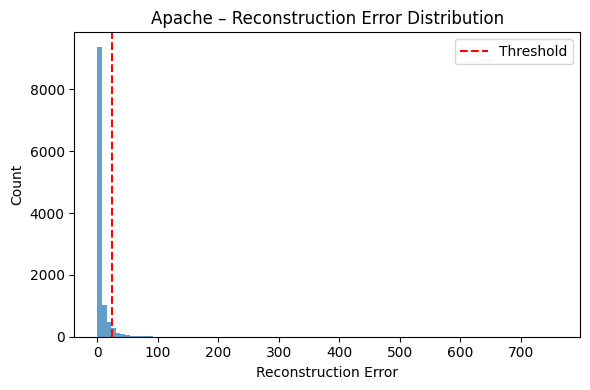

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(reconstruction_error, bins=100, alpha=0.7)
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Apache – Reconstruction Error Distribution")
plt.legend()
plt.tight_layout()
plt.show()


In [59]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent   # notebooks/ -> project root
base = PROJECT_ROOT / "data/raw/Apache"

print("Base path:", base)
print("Exists:", base.exists())


Base path: c:\dev\aiops-logs-anomaly\data\raw\Apache
Exists: True


In [63]:
top_k = 10
top_idx = np.argsort(reconstruction_error)[-top_k:]

print("Top anomalous sequences:")
for i in top_idx:
    print(sequences.iloc[i])

Top anomalous sequences:
[21, 21, 21, 21, 21, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
[18, 42, 18, 42, 18, 42, 18, 42, 18, 42, 18, 42, 18, 42, 21, 21, 21, 21, 21, 21, 21, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 17, 18, 42, 17, 18, 42, 21, 17, 18, 42, 64, 22, 18, 23, 21, 22, 18, 23, 21, 17, 17, 18, 42, 18, 42]
[56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
[59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68]
[36, 36, 36, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 36, 36, 36,

In [64]:
apache_log_path = base / "Apache.log"

with apache_log_path.open(encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

print("Total log lines:", len(lines))
print(lines[:5])

Total log lines: 56482
['[Thu Jun 09 06:07:04 2005] [notice] LDAP: Built with OpenLDAP LDAP SDK\n', '[Thu Jun 09 06:07:04 2005] [notice] LDAP: SSL support unavailable\n', '[Thu Jun 09 06:07:04 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)\n', '[Thu Jun 09 06:07:05 2005] [notice] Digest: generating secret for digest authentication ...\n', '[Thu Jun 09 06:07:05 2005] [notice] Digest: done\n']


In [66]:
from collections import Counter
import math

def sequence_entropy(seq):
    counts = Counter(seq)
    total = len(seq)
    return -sum((c/total) * math.log(c/total + 1e-12) for c in counts.values())

for i in top_idx[:5]:
    seq = sequences.iloc[i]
    print(f"Index {i} | Entropy: {sequence_entropy(seq):.3f}")
    print(seq)
    print("-" * 40)


Index 4279 | Entropy: 0.524
[21, 21, 21, 21, 21, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]
----------------------------------------
Index 6945 | Entropy: 1.750
[18, 42, 18, 42, 18, 42, 18, 42, 18, 42, 18, 42, 18, 42, 21, 21, 21, 21, 21, 21, 21, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 17, 18, 42, 17, 18, 42, 21, 17, 18, 42, 64, 22, 18, 23, 21, 22, 18, 23, 21, 17, 17, 18, 42, 18, 42]
----------------------------------------
Index 9445 | Entropy: -0.000
[56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
----------------------------------------
Index 10140 | Entropy: -0.000
[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
----------------------------------------
Index 9181 | Entropy: -0.000
[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
----------------------------------------
